In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.models as models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import cv2



In [3]:
import os
import cv2
import shutil
from pathlib import Path

# --- Directorios base ---
BASE_DIR = r"C:\Users\josit\CUARTO CURSO\APRENDIZAJE AUTOMATICO\Caso1.-Detecci-n-de-melanomas\data"
OUTPUT_DIR = r"C:\Users\josit\CUARTO CURSO\APRENDIZAJE AUTOMATICO\Caso1.-Detecci-n-de-melanomas\data_heatmap"

# --- Crear directorios de salida ---
for split in ["train", "test"]:
    for cls in ["Benign", "Malignant"]:
        Path(os.path.join(OUTPUT_DIR, split, cls)).mkdir(parents=True, exist_ok=True)

# --- Función para crear heatmap ---
def make_heatmap(image_path, save_path):
    img = cv2.imread(image_path)
    if img is None:
        print(f"⚠ No se pudo leer {image_path}")
        return
    
    # Convertir a gris
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Aplicar GaussianBlur
    heatmap = cv2.GaussianBlur(gray, (15, 15), 0)
    # Normalizar entre 0-255
    heatmap = cv2.normalize(heatmap, None, 0, 255, cv2.NORM_MINMAX)
    # Convertir a 3 canales para guardarlo como imagen
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Guardar imagen
    cv2.imwrite(save_path, heatmap_color)

# --- Recorrer dataset y generar ---
for split in ["train", "test"]:
    for cls in ["Benign", "Malignant"]:
        input_folder = os.path.join(BASE_DIR, split, cls)
        output_folder = os.path.join(OUTPUT_DIR, split, cls)

        for file_name in os.listdir(input_folder):
            if file_name.lower().endswith((".png", ".jpg", ".jpeg")):
                input_path = os.path.join(input_folder, file_name)
                name, ext = os.path.splitext(file_name)
                output_path = os.path.join(output_folder, f"{name}_heatmap{ext}")

                make_heatmap(input_path, output_path)

print("✅ Dataset con heatmaps generado en:", OUTPUT_DIR)


✅ Dataset con heatmaps generado en: C:\Users\josit\CUARTO CURSO\APRENDIZAJE AUTOMATICO\Caso1.-Detecci-n-de-melanomas\data_heatmap


In [2]:
# --- Configuración GPU ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)


Usando dispositivo: cuda


In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import cv2
import numpy as np

# --- Transformación base: resize, to tensor y normalización ---
transform_base = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# --- Transformación personalizada para añadir varias características (heatmap, bordes, simetría) ---
class AddFeatures:
    # El método __call__ permite que esta clase se use como una función sobre un tensor de imagen
    def __call__(self, img_tensor):
        # img_tensor: tensor de 3x224x224 (RGB)
        
        # Convertimos el tensor de PyTorch a un array de NumPy con formato HxWxC
        img_np = img_tensor.permute(1,2,0).numpy()
        
        # Convertimos la imagen a escala de grises (valores 0-255)
        gray = cv2.cvtColor((img_np*255).astype('uint8'), cv2.COLOR_RGB2GRAY)
        
        # --- Heatmap ---
        # Aplicamos un desenfoque gaussiano para crear un heatmap suave
        heatmap = cv2.GaussianBlur(gray, (15,15),0) / 255.0  # normalizamos entre 0 y 1
        heatmap_tensor = torch.tensor(heatmap).unsqueeze(0)  # añadimos dimensión de canal (1xHxW)
        
        # --- Bordes ---
        # Detectamos bordes con el algoritmo de Canny
        edges = cv2.Canny((gray*255).astype('uint8'),50,150)/255.0  # normalizamos entre 0 y 1
        edges_tensor = torch.tensor(edges).unsqueeze(0)  # canal extra para bordes
        
        # --- Simetría ---
        # Volteamos la imagen horizontalmente para comparar ambos lados
        mirror = cv2.flip(gray,1)/255.0
        # Calculamos la diferencia absoluta entre la imagen original y la invertida
        asym = np.abs((gray/255.0)-mirror)  # zonas asimétricas tendrán valores altos
        asym_tensor = torch.tensor(asym).unsqueeze(0)  # canal extra para asimetría
        
        # --- Combinamos todos los canales ---
        # Concatenamos la imagen original (3 canales) + heatmap + bordes + asimetría => tensor de 6 canales
        return torch.cat([img_tensor, heatmap_tensor, edges_tensor, asym_tensor], dim=0)  # 6xHxW

# --- Transformación completa: base + heatmap ---
transform_full = transforms.Compose([
    transform_base,
    AddFeatures()
])

# --- Cargar datasets con la transformación completa ---
train_data = datasets.ImageFolder(
    root=r"C:\Users\josit\CUARTO CURSO\APRENDIZAJE AUTOMATICO\Caso1.-Detecci-n-de-melanomas\data\train",
    transform=transform_full
)

test_data = datasets.ImageFolder(
    root=r"C:\Users\josit\CUARTO CURSO\APRENDIZAJE AUTOMATICO\Caso1.-Detecci-n-de-melanomas\data\test",
    transform=transform_full
)

# --- DataLoaders ---
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# --- Verificar clases ---
print("Clases:", train_data.classes)

# --- Verificar tamaño de un batch ---
for images, labels in train_loader:
    print("Tamaño batch de imágenes:", images.shape)  # debería ser [32, 4, 224, 224]
    print("Tamaño batch de labels:", labels.shape)
    break


Clases: ['Benign', 'Malignant']
Tamaño batch de imágenes: torch.Size([32, 6, 224, 224])
Tamaño batch de labels: torch.Size([32])


Usando dispositivo: cuda
Epoch 1/40 | Train Loss: 0.4791 | Train Acc: 0.7717 | Val Loss: 0.6263 | Val Acc: 0.7405
Epoch 2/40 | Train Loss: 0.4412 | Train Acc: 0.7976 | Val Loss: 0.4780 | Val Acc: 0.8030
Epoch 3/40 | Train Loss: 0.4313 | Train Acc: 0.7980 | Val Loss: 0.4573 | Val Acc: 0.7895
Epoch 4/40 | Train Loss: 0.4030 | Train Acc: 0.8105 | Val Loss: 0.4537 | Val Acc: 0.7845
Epoch 5/40 | Train Loss: 0.3819 | Train Acc: 0.8239 | Val Loss: 0.3938 | Val Acc: 0.8200
Epoch 6/40 | Train Loss: 0.3574 | Train Acc: 0.8353 | Val Loss: 0.3637 | Val Acc: 0.8330
Epoch 7/40 | Train Loss: 0.3352 | Train Acc: 0.8515 | Val Loss: 0.3344 | Val Acc: 0.8725
Epoch 8/40 | Train Loss: 0.3290 | Train Acc: 0.8556 | Val Loss: 0.3240 | Val Acc: 0.8705
Epoch 9/40 | Train Loss: 0.3143 | Train Acc: 0.8633 | Val Loss: 0.3597 | Val Acc: 0.8330
Epoch 10/40 | Train Loss: 0.3189 | Train Acc: 0.8596 | Val Loss: 0.3323 | Val Acc: 0.8710
Epoch 11/40 | Train Loss: 0.3092 | Train Acc: 0.8627 | Val Loss: 0.3491 | Val Acc: 0

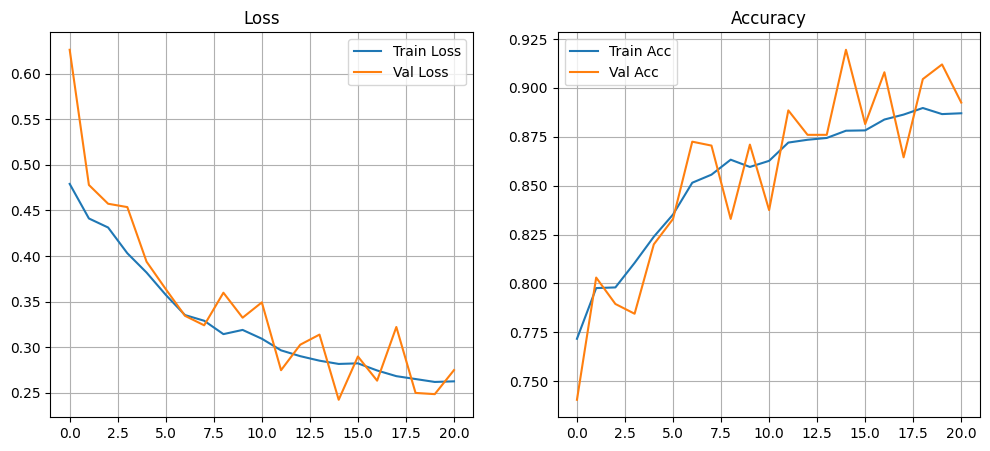

In [12]:

# --- Configuración GPU ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)


# --- Modelo CNN más profundo ---
class CNNFeatures(nn.Module):
    def __init__(self, num_classes):
        super(CNNFeatures, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(6, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1))
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )
    
    def forward(self,x):
        x = self.features(x)
        x = torch.flatten(x,1)
        x = self.classifier(x)
        return x

model = CNNFeatures(len(train_data.classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# --- Entrenamiento con early stopping ---
num_epochs = 40
patience = 6
best_val_loss = float('inf')
counter = 0

train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
best_model_state = None

for epoch in range(num_epochs):
    model.train()
    running_loss, correct_train, total_train = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device).float(), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        correct_train += (outputs.argmax(1) == labels).sum().item()
        total_train += labels.size(0)
    
    train_loss = running_loss / len(train_loader.dataset)
    train_acc = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    # --- Validación ---
    model.eval()
    val_loss, correct_val, total_val = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device).float(), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            correct_val += (outputs.argmax(1) == labels).sum().item()
            total_val += labels.size(0)
    val_loss /= len(test_loader.dataset)
    val_acc = correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        counter = 0
    else:
        counter +=1
        if counter >= patience:
            print(f"⛔ Early stopping en epoch {epoch+1}")
            break

# --- Guardar mejor modelo ---
if best_model_state:
    torch.save({
        'model_state': best_model_state,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies
    }, 'best_model_features.pth')

# --- Graficar Accuracy y Loss ---
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend(); plt.grid(True); plt.title("Loss")
plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.legend(); plt.grid(True); plt.title("Accuracy")
plt.show()


In [14]:
model.eval()  # modo evaluación
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.float()
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)  # la clase con mayor probabilidad
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


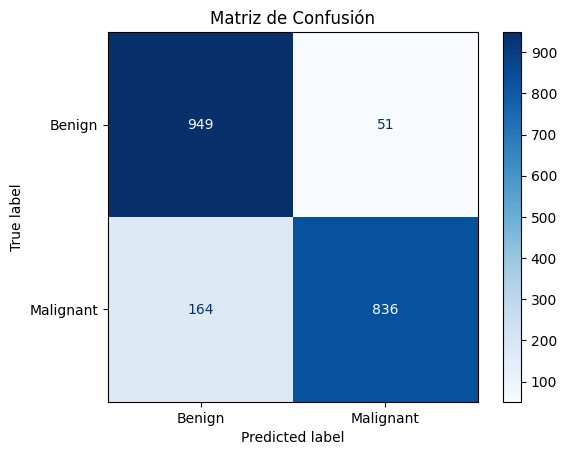

In [15]:
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_data.classes)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión")
plt.show()


In [ ]:

# --- Configuración GPU ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)


# --- Modelo CNN más profundo ---
class CNNFeatures(nn.Module):
    def __init__(self, num_classes):
        super(CNNFeatures, self).__init__()
        self.features = nn.Sequential(
            # Bloque 1: Conv → Pool
            nn.Conv2d(6, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # Bloque 2: Conv → Pool
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # Bloque 3: Conv → Pool
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # Bloque 4: Conv → Pool (puede ser Adaptive para tamaño final)
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1))
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x



model = CNNFeatures(len(train_data.classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# --- Entrenamiento con early stopping ---
num_epochs = 40
patience = 5
best_val_loss = float('inf')
counter = 0

train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
best_model_state = None

for epoch in range(num_epochs):
    model.train()
    running_loss, correct_train, total_train = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device).float(), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        correct_train += (outputs.argmax(1) == labels).sum().item()
        total_train += labels.size(0)
    
    train_loss = running_loss / len(train_loader.dataset)
    train_acc = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    # --- Validación ---
    model.eval()
    val_loss, correct_val, total_val = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device).float(), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            correct_val += (outputs.argmax(1) == labels).sum().item()
            total_val += labels.size(0)
    val_loss /= len(test_loader.dataset)
    val_acc = correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        counter = 0
    else:
        counter +=1
        if counter >= patience:
            print(f"⛔ Early stopping en epoch {epoch+1}")
            break

# --- Guardar mejor modelo ---
if best_model_state:
    torch.save({
        'model_state': best_model_state,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies
    }, 'best_model_features.pth')

# --- Graficar Accuracy y Loss ---
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend(); plt.grid(True); plt.title("Loss")
plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.legend(); plt.grid(True); plt.title("Accuracy")
plt.show()


Usando dispositivo: cuda
Epoch 1/40 | Train Loss: 0.4719 | Train Acc: 0.7817 | Val Loss: 0.4987 | Val Acc: 0.7565
Epoch 2/40 | Train Loss: 0.4106 | Train Acc: 0.8183 | Val Loss: 0.4174 | Val Acc: 0.8155
Epoch 3/40 | Train Loss: 0.3750 | Train Acc: 0.8393 | Val Loss: 0.3808 | Val Acc: 0.8325
